## Trayendo datos

In [2]:
import pandas as pd
import pylab as plt
from tusp import string2ts, ts2string
from bot import prepareData,marketReturn
import numpy as np
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 8

# trayendo y preparando datos
df  = prepareData(pair="BTC_XRP",
                  start=string2ts("2017-07-01 00:00:00"),
                  end=string2ts("2018-03-01 00:00:00"),
                  period=3600*4)
per = 0.85


## Parámetros vía stockstacks

In [3]:
from stockstats import StockDataFrame

stock = StockDataFrame.retype(df.copy())
stock["rsi_14"];
stock["macd"];
stock["macds"];
stock["cci"];
stock["wr_14"];

C:\Users\Daniel.LAPTOP-OBVONK0N\Anaconda2\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Creando estrategia ideal y separando en train y test 

In [4]:
from mldata import ml_data
from orders import orders
from profit import profit

df["ml_data"] = ml_data(df["close"],la=10, pl=False)

w4 = pd.DataFrame(data={"w":df["ml_data"].values,"price":df["close"]})
w4["orders"] = orders(w4["w"])
w4["w"] = w4["w"].shift(1)
relReturn, vecReturn4 = profit(w4)
print "Retorno de estrategia ideal: %s"%(relReturn*100)

data = pd.DataFrame(data={"price":df["close"],"pricew":df["weightedAverage"],"volumen":df["volume"],
                          "rsi":stock["rsi_14"],"macd":stock["macd"],"macds":stock["macds"],"cci":stock["cci"],
                          "wr":stock["wr_14"],"ideal_w":w4["w"],"volatility": df["volatility"],"close":df["close"],"kdjk":stock["kdjk"],
                          "kdjd":stock["kdjd"],"kdjj":stock["kdjj"], "dma":stock["dma"], "trix":stock["trix"],
                          "vr":stock["vr"]})

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(method='bfill', inplace=True)

train = data[1:int(len(data)*per)]
test = data[int(len(data)*per):]

train.tail()

Retorno de estrategia ideal: 42405.599523


,cci,close,dma,ideal_w,kdjd,kdjj,kdjk,macd,macds,price,pricew,rsi,trix,volatility,volumen,vr,wr
date,,,,,,,,,,,,,,,,,
2018-01-22 19:00:00,114.901357,0.000122,-0.000005,1.0,44.491601,92.353375,60.445526,-0.000002,-0.000002,0.000122,0.000122,50.230005,-0.355745,False,1108.483996,40.238765,18.633540
2018-01-22 23:00:00,57.322808,0.000120,-0.000004,1.0,50.316779,85.267846,61.967134,-0.000002,-0.000002,0.000120,0.000120,47.393459,-0.335701,True,542.760002,45.259988,34.989648
2018-01-23 03:00:00,54.807124,0.000120,-0.000004,1.0,54.630383,80.512011,63.257593,-0.000002,-0.000002,0.000120,0.000120,47.554950,-0.312800,False,558.331852,35.501154,34.161491
2018-01-23 07:00:00,176.899243,0.000125,-0.000003,1.0,59.638420,89.686640,69.654493,-0.000001,-0.000002,0.000125,0.000124,54.137682,-0.273059,True,1068.716270,45.374908,17.551705
2018-01-23 11:00:00,130.454900,0.000122,-0.000002,1.0,62.429823,79.178240,68.012629,-0.000001,-0.000002,0.000122,0.000124,50.023513,-0.233881,False,720.570287,38.468249,35.271101


## Importando modelos de clasificación

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

features = ["price","rsi","cci","macds","macd","wr","trix","vr"]

X, y = data[features], data["ideal_w"]

## Validación cruzada XGBoost 

Se obtienen los valores:
* n_estimators = 9
* learning_rate = 0.75
* gamma = 12

### base_score

In [5]:
# tuneado de base_score

params = np.linspace(0.01, 0.99, 10)
#params = np.logspace(-10, 0, 10)
xgb = XGBClassifier()

scores = list()
scores_std = list()

for bs in params:
    xgb.base_score = bs
    
    this_scores = cross_val_score(xgb, X, y, n_jobs=-1);
    
    # calculando promedio y std de las validaciones cruzadas
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))
    

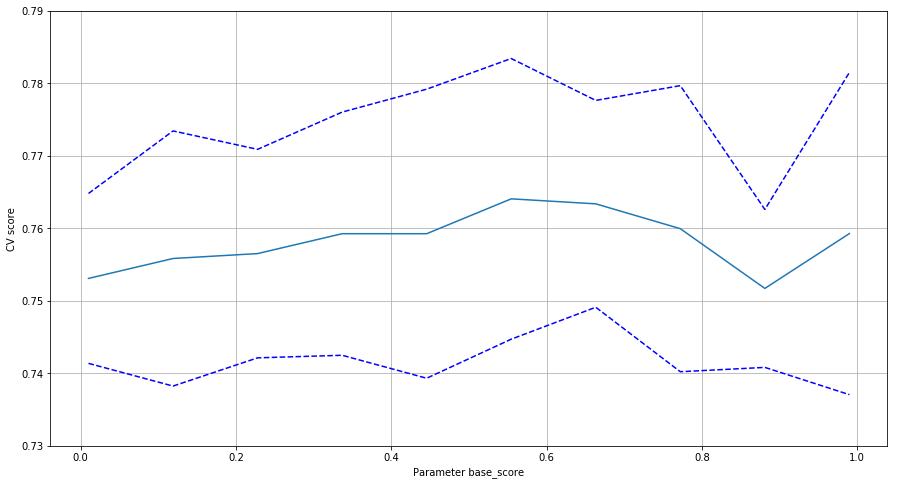

In [6]:
plt.plot(params, scores)
plt.plot(params, np.array(scores) + np.array(scores_std), 'b--')
plt.plot(params, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter base_score')
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### n_estimators

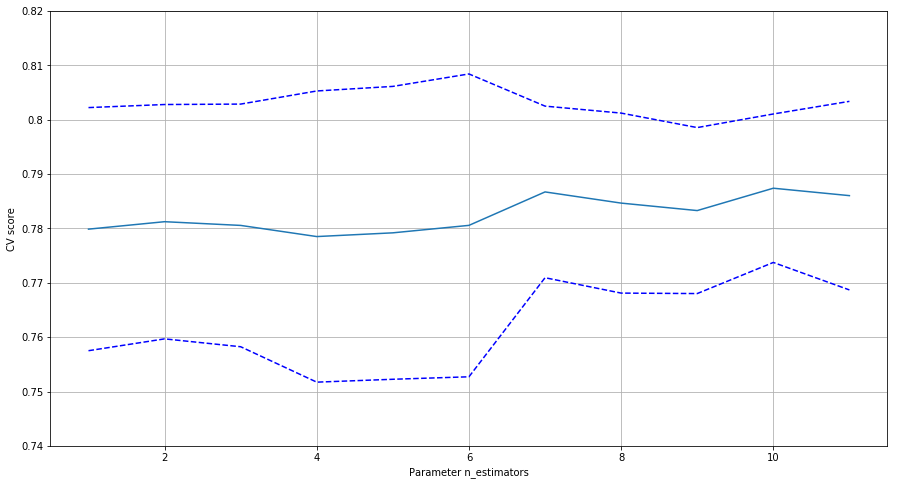

In [7]:
parameter = "n_estimators"
params = range(1,12)
#params = np.logspace(-10, 0, 10)
xgb = XGBClassifier()

scores = list()
scores_std = list()

for bs in params:
    xgb.n_estimators = bs
    
    this_scores = cross_val_score(xgb, X, y, n_jobs=-1)
    
    # calculando promedio y std de las validaciones cruzadas
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

plt.plot(params, scores)
plt.plot(params, np.array(scores) + np.array(scores_std), 'b--')
plt.plot(params, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### learning_rate

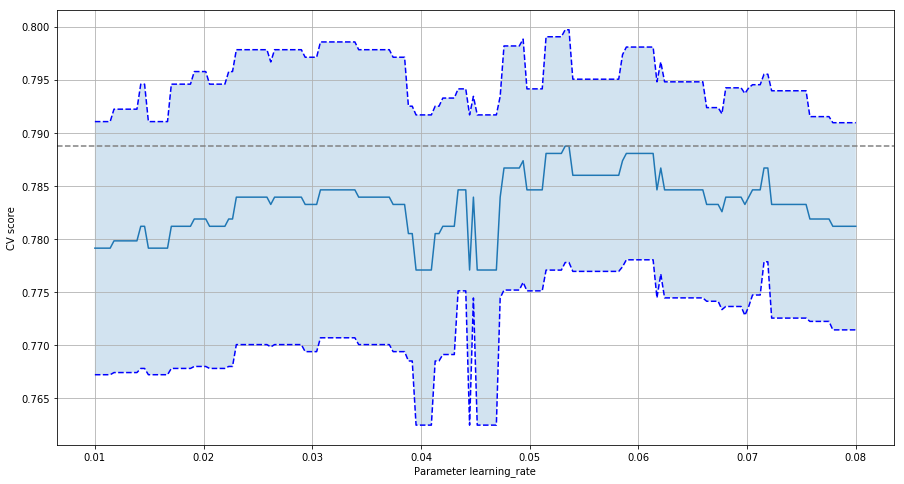

In [8]:
parameter = "learning_rate"
alphas = np.linspace(0.01, 0.08, 200)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(xgb, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### max_depth

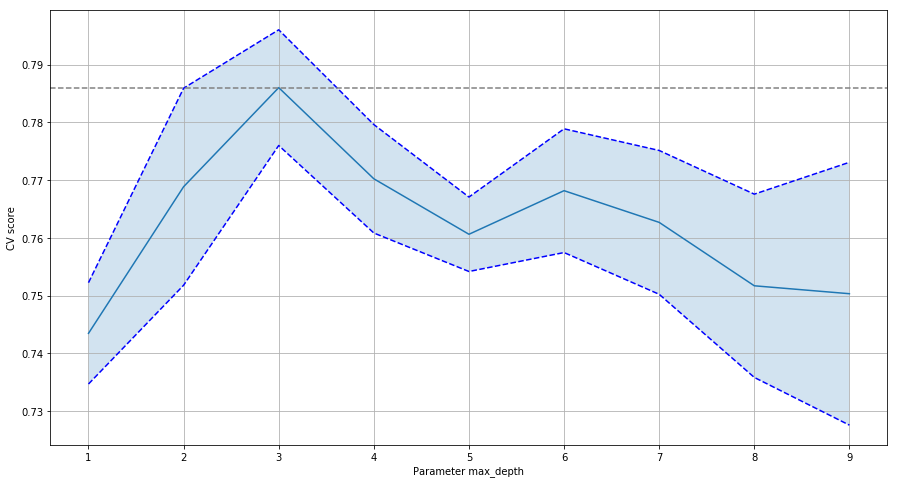

In [9]:
parameter = "max_depth"
alphas = range(1,10)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(xgb, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### gamma

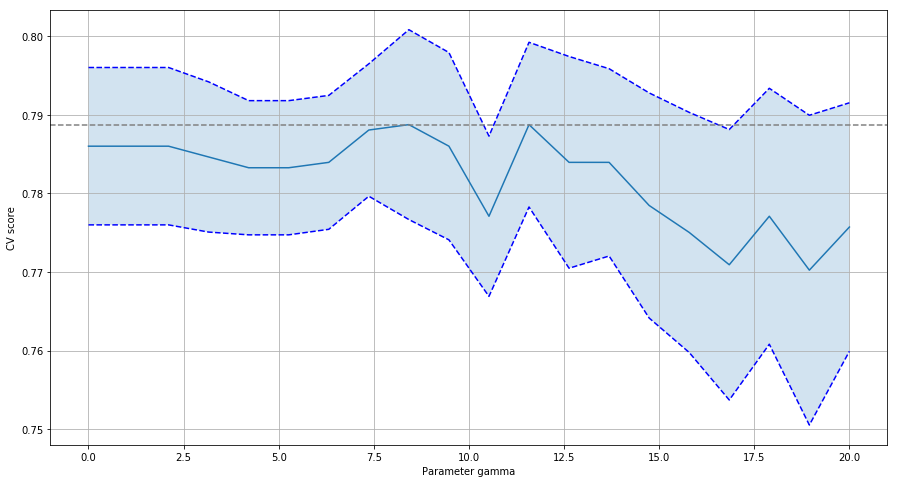

In [10]:
parameter = "gamma"
alphas = np.linspace(0, 20, 20)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(xgb, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

## DecisionTreeClassifier

### max_depth

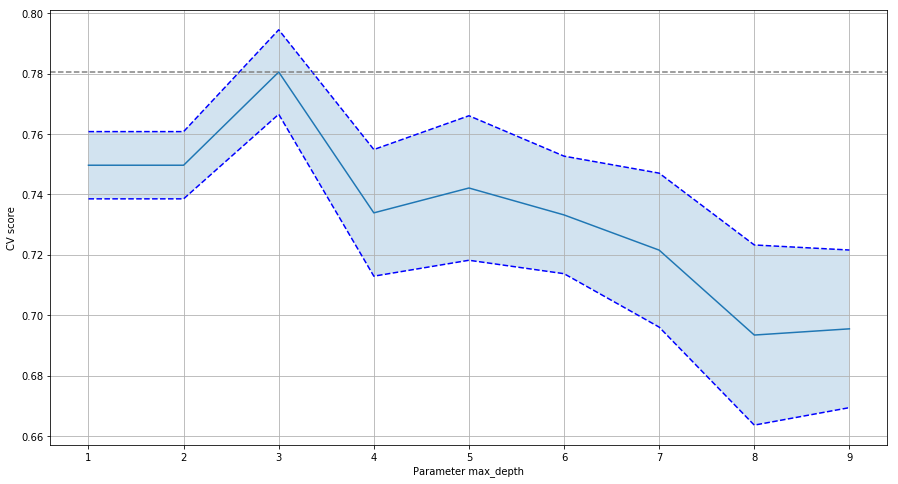

In [11]:
decision_tree = DecisionTreeClassifier()

parameter = "max_depth"
alphas = range(1,10)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(decision_tree, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### min_samples_split

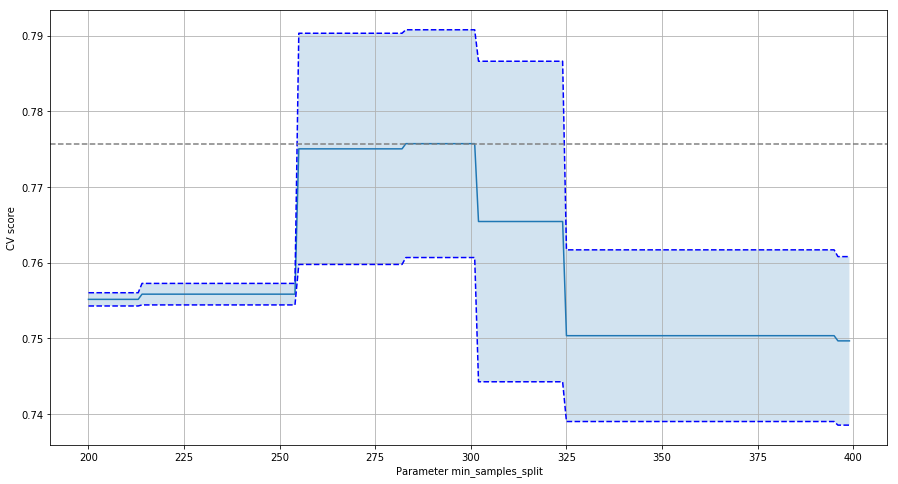

In [12]:
parameter = "min_samples_split"
alphas = range(200,400)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(decision_tree, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### min_samples_leaf

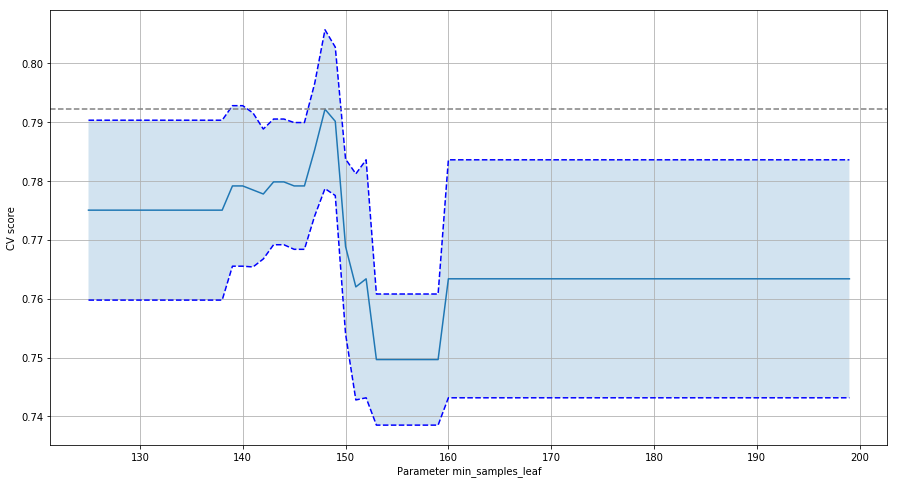

In [13]:
parameter = "min_samples_leaf"
alphas = range(125,200)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(decision_tree, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

## random forest

### n_estimators

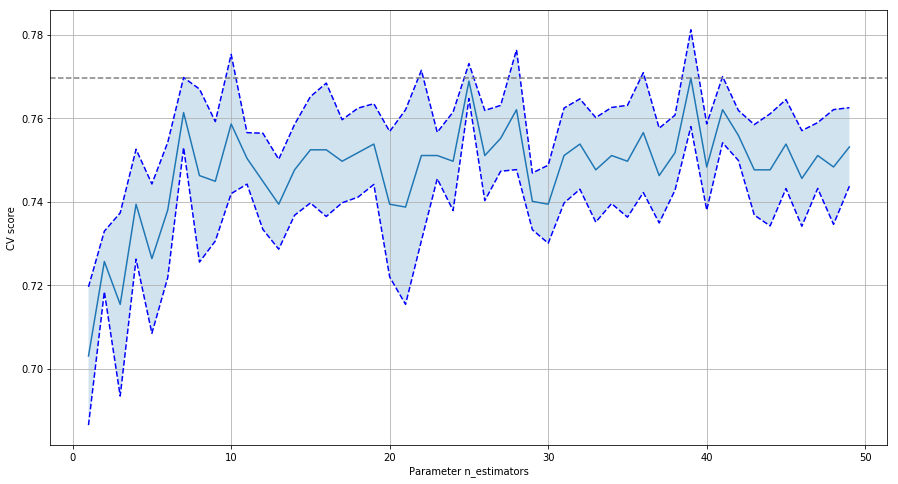

In [14]:
random_forest = RandomForestClassifier()

parameter = "n_estimators"
alphas = range(1,50)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(random_forest, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### max_depth

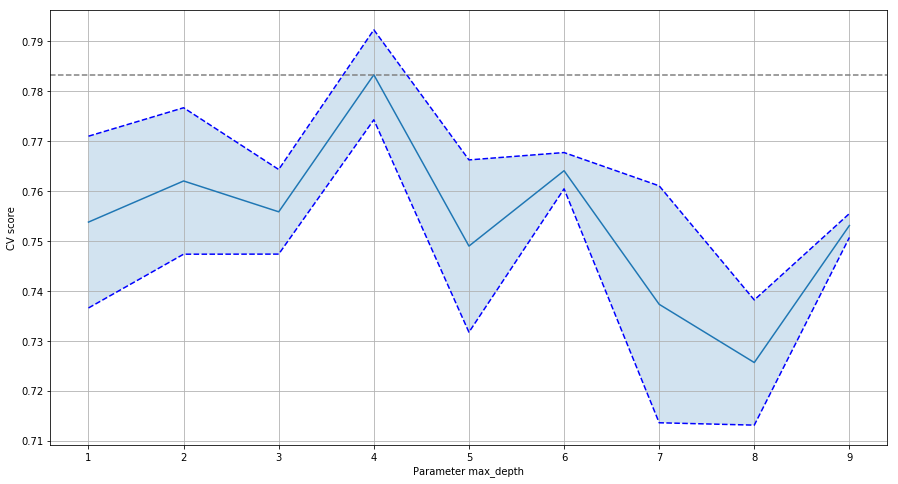

In [15]:
parameter = "max_depth"
alphas = range(1,10)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(random_forest, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### min_samples_split

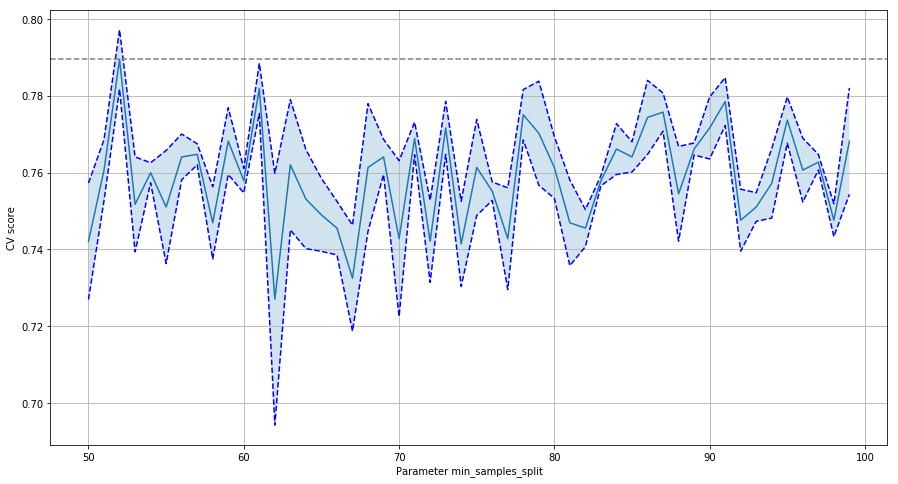

In [16]:
parameter = "min_samples_split"
alphas = range(50,100)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(random_forest, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### min_samples_leaf

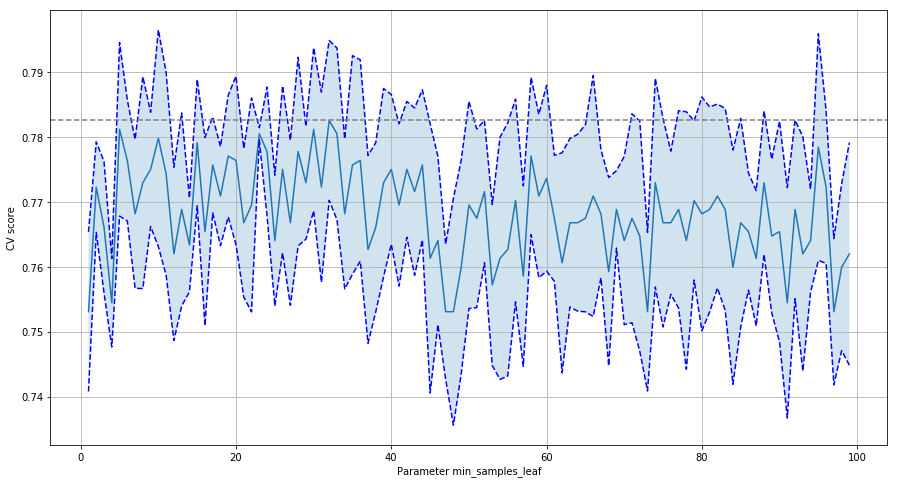

In [17]:
parameter = "min_samples_leaf"
alphas = range(1,100)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(random_forest, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

## Regresion logistica

### C

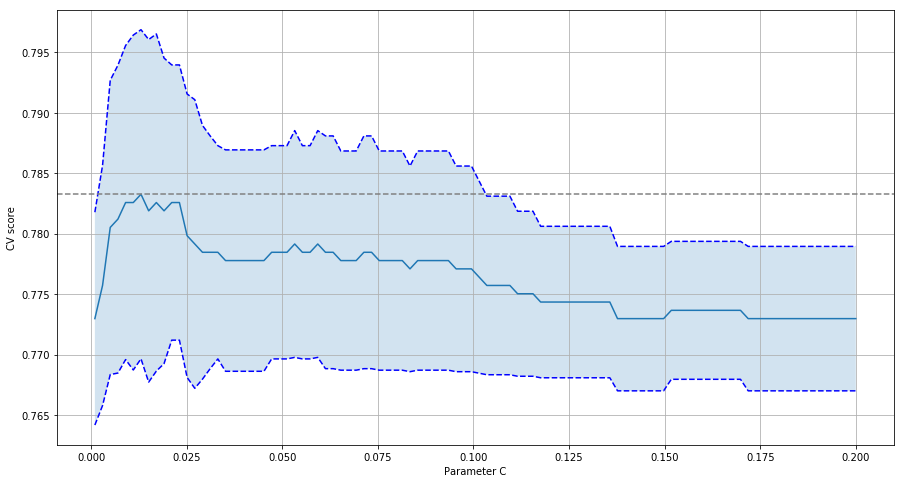

In [18]:
logreg = LogisticRegression()

parameter = "C"
alphas = np.linspace(0.001,0.2,100)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(logreg, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

## MPLC

### alpha

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   48.4s finished


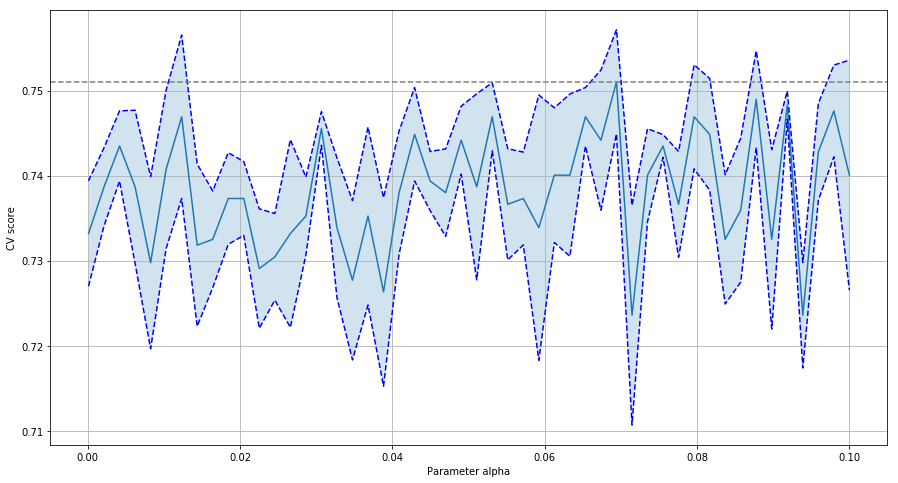

In [19]:
mlpc = MLPClassifier(solver='lbfgs')

parameter = "alpha"
alphas = np.linspace(0.0001,0.1,50)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(mlpc, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1, verbose=1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### hidden_layer_sizes 1

Fitting 3 folds for each of 79 candidates, totalling 237 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 237 out of 237 | elapsed:   42.2s finished


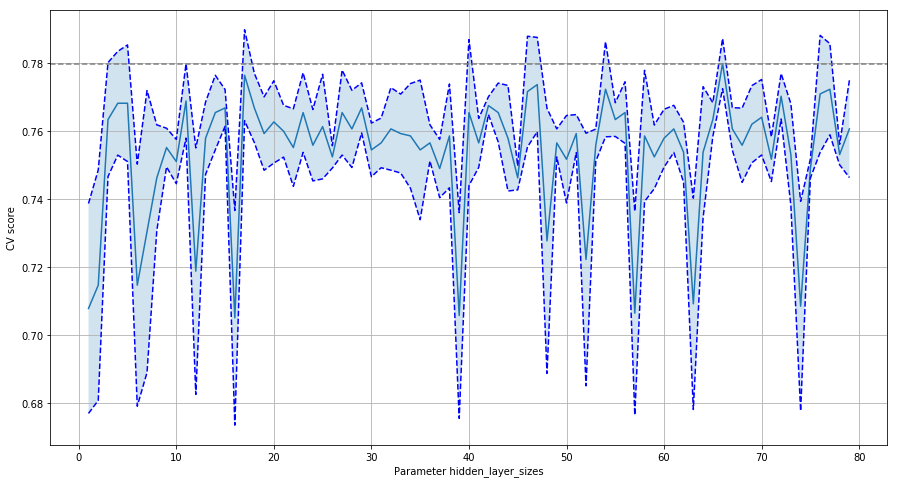

In [20]:
mlpc = MLPClassifier(solver='lbfgs')

parameter = "hidden_layer_sizes"
a = range(1,80)
alphas = [(2,i) for i in a]
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(mlpc, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1, verbose=2)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']


alphas = a
plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### hidden_layer_sizes 2

Fitting 3 folds for each of 79 candidates, totalling 237 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 237 out of 237 | elapsed:  1.2min finished


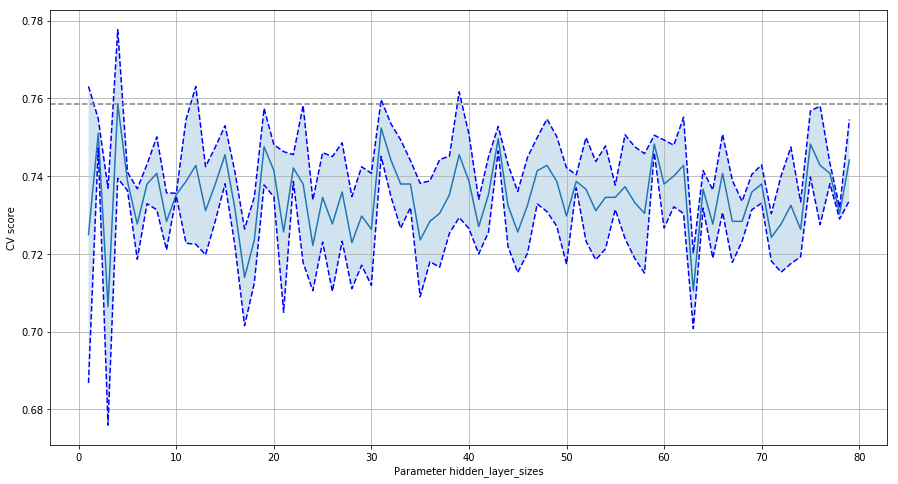

In [ ]:
parameter = "hidden_layer_sizes"
a = range(1,80)
alphas = [(i,30) for i in a]
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(mlpc, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1, verbose=2)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']


alphas = a
plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

## AdaBoost

### n_estimators

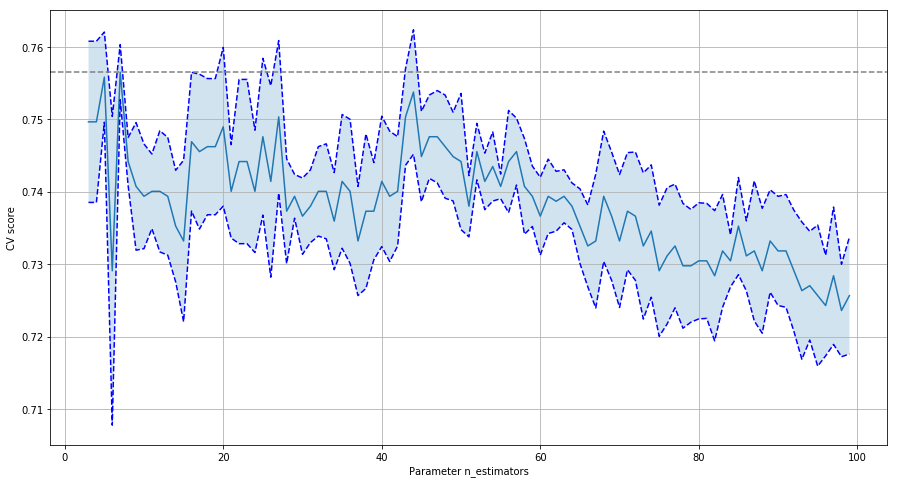

In [15]:
ada = AdaBoostClassifier()

parameter = "n_estimators"
alphas = range(3,100)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(ada, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

## learning_rate

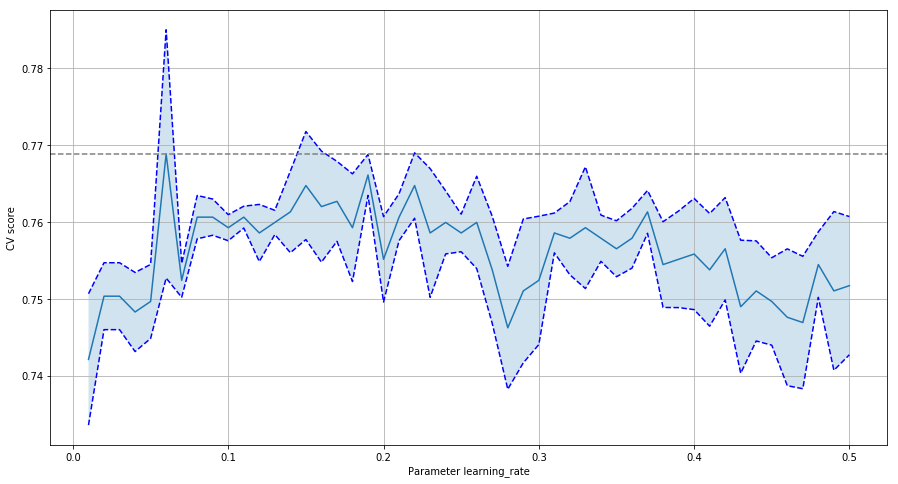

In [25]:
parameter = "learning_rate"
alphas = np.linspace(0.01,0.5,50)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(ada, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### algorithm

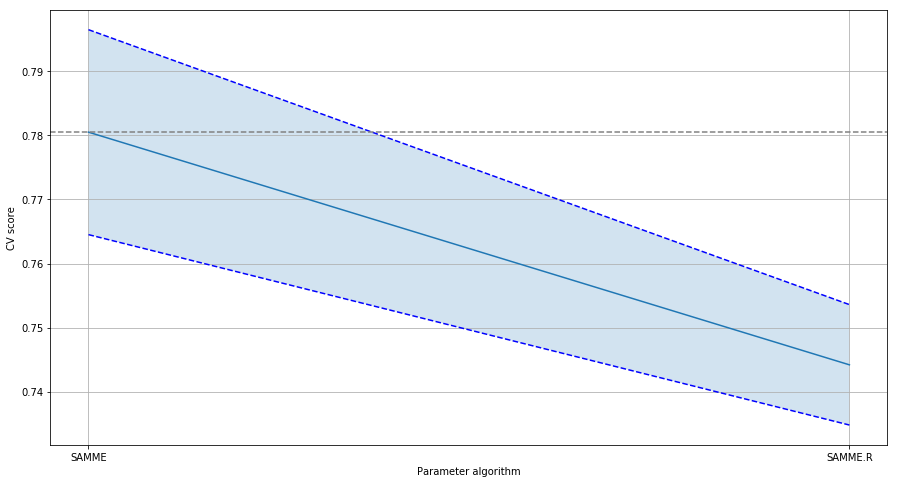

In [26]:
parameter = "algorithm"
alphas = ['SAMME', 'SAMME.R']
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(ada, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

## KNeighborsClassifier

## n_neighbors = 218

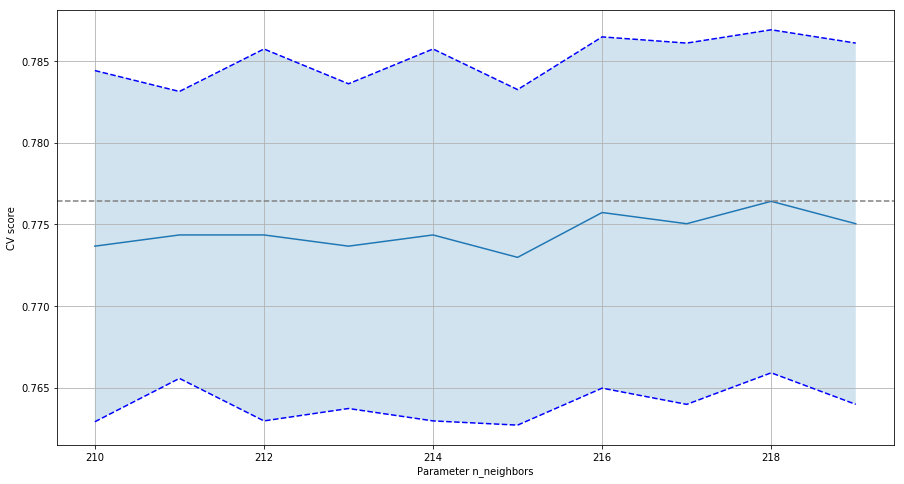

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

parameter = "n_neighbors"
alphas = range(210,220)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(knn, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### weights = "distance"

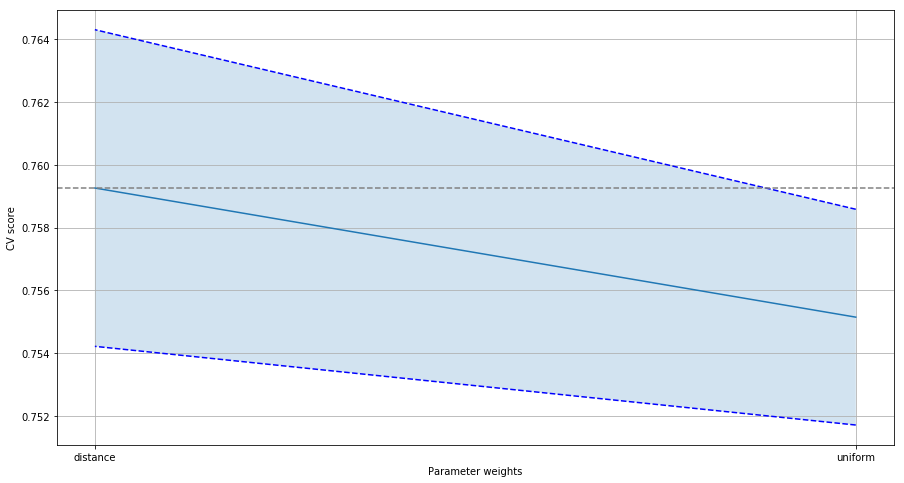

In [34]:
parameter = "weights"
alphas = ["uniform", "distance"]
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(knn, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

In [28]:
help(knn)

Help on KNeighborsClassifier in module sklearn.neighbors.classification object:

class KNeighborsClassifier(sklearn.neighbors.base.NeighborsBase, sklearn.neighbors.base.KNeighborsMixin, sklearn.neighbors.base.SupervisedIntegerMixin, sklearn.base.ClassifierMixin)
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, optional (default = 5)
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : str or callable, optional (default = 'uniform')
 |      weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of their distance.
 |        in this case, closer neighbors of a query point will have a
 |        greater influence than neighbors which are further away.
 |      - [c

C:\Users\Daniel.LAPTOP-OBVONK0N\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


array([], dtype=float64)